# **DIABETES DATASET**

# **About the Dataset**

The diabetes data containing information about PIMA Indian females, near Phoenix, Arizona has been under continuous study since 1965 due to the high incidence rate of Diabetes in PIMA females. The dataset was originally published by the National Institute of Diabetes and Digestive and Kidney Diseases, consisting of diagnostic measurements pertaining to females of age greater than 20. It contains information of 768 females, of which 268 females were diagnosed with Diabetes. Information available includes 8 variables, such as, Age, Number of Pregnancies, Glucose, Insulin, etc. More detailed description about the variables is listed in the table below. The response variable in the dataset is a binary classifier, Outcome, that indicates if the person was diagnosed with Diabetes or not.


# 1. Examine the content of the dataset.

Required Libraries and Settings


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor #cok degiskenli aykiri deger yakalama yontemi
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [2]:
df.Pregnancies.dtypes

dtype('int64')

# 2. Find numeric and categorical variables.

If the number of classes of a numeric variable in a variable is less than 10, this variable is a categorical variable with a numerical appearance.
- Who are the numerical variables? Who are the categorical variables?
- Who are the seemingly categorical but not categorical (cardinals)?
- Who are the categorical ones that look like numbers?

In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
     It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included in categorical variables.
     parameters
     -------
         dataframe: dataframe
             The dataframe from which variable names are to be retrieved
         cat_th: int optional
             class threshold for numeric but categorical variables
         car_th: int, optional
             class threshold for categorical but cardinal variables
     Returns
     -------
         cat_cols: list
             Categorical variable list
         num_cols: list
             Numeric variable list
    """

# There are 3 concepts here: 1.Categorical variable: Gender, 2.Numerical Variable,
# 3. Categorical Variable with Numeric View

# Categorical Variables with Numeric View
# Variables that look categorical but carry no information. Variables with high cardinality.
# There are variables that normally appear to be categorical but not categorical.


     # cat_cols, cat_but_car
     # here first categorical variables are selected.
     # then numeric but categorical ones are selected.

     # If the number of classes of a numeric variable in a variable is less than 10, this variable is categorical with a numeric appearance.
     # To catch this, look at the number of variables in the relevant variable, if it is less than the threshold (cat_th) I specified and the type of the variable is not object,
     # ie catch variables that are stored numeric but categorical.
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    # I set car_th for categorical but cardinal variables.
    # A categorical variable is not measurable if the number of unique classes is greater than 20. If there are as many classes as the observation class
    cat_but_car = [col for col in dataframe.columns if dataframe [col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    # cat_cols listemizi baştan oluşturduk. Bir cat_cols listem vardı ama bir de numerik görünümlü kategorikler vardı.
    cat_cols = cat_cols + num_but_cat
    # There were variables with high cardinality in cat_cols, I'm doing them here as well.
    # When I say select categorical but not cardinal, cat_cols is now clean.
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # HERE NOW: There are categorical ones, there are categorical ones that look numerical, and there are categorical but cardinal ones.

    # num_cols
    # here we bring those whose type is different from object. inf and floats will come.
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    # There were categorical ones that looked like #numerical but we remove them from here.
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # THUS I HAVE: I have True Numerics, True Categoricals, and Cardinals.
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


# 3. Analyze numerical and categorical variables
- Who are the categorical variables to the diabetes dataset here? Who are the numerical values? we asked the question of non-functional variables kmler.
- Now we will ask this dataframe for check_outliers.

In [4]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


**Multivariate Outlier Analysis: Local Outlier Factor**

Some structures that are not significant on their own, when evaluated together, create a multivariate outlier.

How many observations are in this dataset?

In [7]:
df.shape

(768, 9)

In [8]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


It's an outlier in the insulin variable and we'll see how many outliers there are

In [9]:
low, up = outlier_thresholds(df, "Insulin")
df[((df["Insulin"] < low) | (df["Insulin"] > up))].shape

(2, 9)

There seem to be 2 outliers.
Outlier threshold was 25 to 75.
We know that we can use it as 5 to 95. If we approached the subject with a single variable and deleted or filled in 0 to 95, there would have been a serious loss of data.
If we are using tree methods, we should prefer not to to

In [10]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [11]:
df_scores = clf.negative_outlier_factor_

Let's observe 5 LocalOutlierFactor scores

In [12]:
df_scores[0:5]

array([-1.06670781, -1.00444029, -1.07964805, -0.9796959 , -1.16949099])

The higher, the more normal. Inliers tend to have a LOF score close to 1

I can use this way when I don't want to observe them with negative values.
df_scores = -df_scores

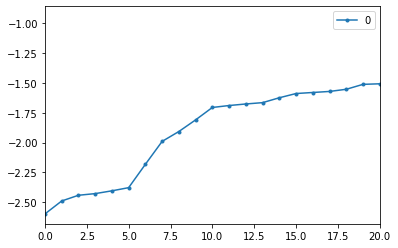

In [13]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

In [14]:
th = np.sort(df_scores)[3]

In [15]:
df[df_scores < th]
df[df_scores < th].shape

(3, 9)

In [16]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T
df[df_scores < th].index

Int64Index([13, 342, 502], dtype='int64')

# 4. Perform target variable analysis. 
(The mean of the target variable according to the categorical variables, the mean of the numeric variables according to the target variable)

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


target_summary_with_cat(df, "Insulin", "Age")

for col in cat_cols:
    target_summary_with_cat(df, "Insulin", col)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


target_summary_with_num(df, "Insulin", "Age")

for col in num_cols:
    target_summary_with_num(df, "Insulin", col)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
     TARGET_MEAN
Age             
21        73.635
22        74.486
23       118.026
24        88.022
25        82.896
26        90.879
27        63.125
28        94.600
29        88.793
30        82.667
31       111.167
32        35.812
33        85.588
34       148.071
35        75.000
36        65.812
37        59.263
38        33.500
39        72.417
40        72.308
41        38.818
42        61.278
43       125.154
44        32.250
45        31.133
46       112.308
47        49.167
48        52.000
49        55.200
50        26.375
51       129.375
52        94.500
53       183.000
54        61.000
55        83.750
56        69.000
57        78.000
58       167.857
59       282.000
60       164.200
61        95.000
62         0.000
63        45.000
64         0.000
65         0.000
66         0.000
67         0.000
68         0.000
69         0.000
70         0.000
72         0.000
81        60.0

In [18]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

# 5. Perform outlier observation analysis.

# Outliers

- Catch outliers.
- Check for outliers.

In [19]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


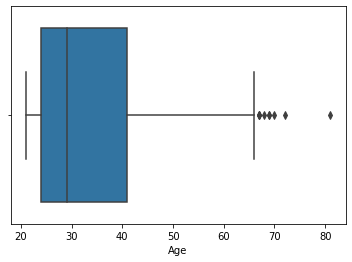

In [20]:
sns.boxplot(x=df["Age"])
plt.show()

- boxplot returns the distribution information of a numeric variable.

1. I set a threshold value.
2. I have reached outliers.
3. Are there any outliers or not?

In [21]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [22]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for i in df.columns:
 low, up = outlier_thresholds(df, i)
 if ((df[i] < low) | (df[i] > up)).any():
      print(f"\nIndices: {df[(df[i] < low) | (df[i] > up)].index}\n")
      print(df[(df[i] < low) | (df[i] > up)].head())
      replace_with_thresholds(df,i)

outlier_thresholds(df, "Age")


Indices: Int64Index([13, 228], dtype='int64')

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
13             1      189             60             23      846 30.100                     0.398   59        1
228            4      197             70             39      744 36.700                     2.329   31        0


(-34.5, 113.5)

In [23]:
low, up = outlier_thresholds(df, "Age")

df[(df["Age"] < low) | (df["Age"] > up)].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


- Is there an outlier or not? It is necessary to generalize this to adapt it to a different variable each time.
- I called outlier_thresholds and entered the necessary parameters.
- If; If we want to format the other arguments of the outlier_thresholds function from the check_outlier function, so I have to enter Q1 and Q3 as arguments here.

In [24]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")

False

# 6. Perform a missing observation analysis.

Query whether there is a missing value in the entire dataset

In [25]:
df.isnull().values.any()

False

# 7. Perform correlation analysis.

In [26]:
num_cols = [col for col in df.columns if df[col].dtype in [int, float]]

corr = df[num_cols].corr()
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.073,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.090,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.440,0.393,0.184,-0.114,0.075
Insulin,-0.073,0.331,0.090,0.440,1.000,0.200,0.186,-0.045,0.130
BMI,0.018,0.221,0.282,0.393,0.200,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.186,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.045,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.130,0.293,0.174,0.238,1.000


<AxesSubplot:>

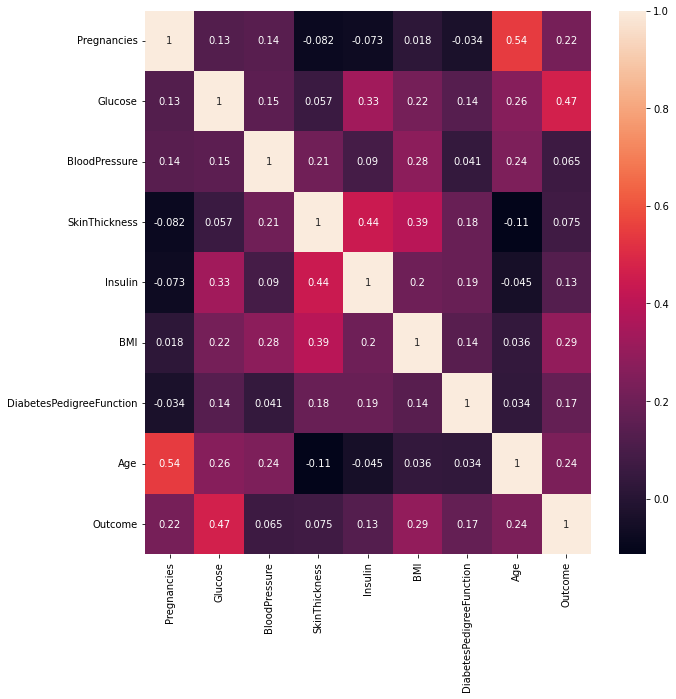

In [27]:
df.shape
df.head()

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

In [28]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

# - Step 1. 
Take necessary actions for missing and outlier values. There are no missing observations in the data set, but Glucose, Insulin etc. Observation units containing 0 in the variables may represent the missing value. E.g; a person's glucose or insulin value will not be 0. Considering this situation, you can assign the zero values to the relevant values as NaN and then apply the operations to the missing values.

In [29]:
df.head()

cols = ["Pregnancies","Glucose","Insulin"]
for i in cols:
    df[i] = df[i].replace({'0': np.nan, 0: np.nan})

In [30]:
df[cols].head()

df = df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72,35,125.000,33.600,0.627,50,1
1,1.000,85.000,66,29,125.000,26.600,0.351,31,0
2,8.000,183.000,64,0,125.000,23.300,0.672,32,1
3,1.000,89.000,66,23,94.000,28.100,0.167,21,0
4,4.000,137.000,40,35,168.000,43.100,2.288,33,1


# - Step 2.
Create new variables.

- The main goal is to model whether humans will survive or not, on this dataset.
- Let's bring all the names of the variables into one format and enlarge them all.
- Navigate through the df columns, enlarge any name you catch.

In [31]:
df.columns = [col.upper() for col in df.columns]

I want the NaN variables in the insulin variable to link to Age and create a new variable.
I asked if the PREGNANCIES values here are full or empty and I converted them to 1 - 0.

In [32]:
df["NEW_PREGNANCIES_BOOL"] = df["PREGNANCIES"].notnull().astype('int')


df.groupby("NEW_PREGNANCIES_BOOL").agg({"AGE": "mean"})

df.loc[((df['GLUCOSE'] + df['INSULIN']) > 0), "DIET"] = 1
df.loc[((df['GLUCOSE'] + df['INSULIN']) <= 0), "DIET"] = 0

df.groupby("DIET").agg({"AGE":"mean"})


df["NEW_AGE_INSULIN"] = df["AGE"] * df["INSULIN"]

df["INSULIN_OUTCOME"] = df["INSULIN"] * df["OUTCOME"]

df.head()

df["INSULIN_OUTCOME"] = df["INSULIN"].notnull().astype('int')


df.groupby("INSULIN_OUTCOME").agg({"OUTCOME": "mean"})

df["INSULIN_PREGNANCIES"] = df["INSULIN"].notnull().astype('int')

df.groupby("INSULIN_PREGNANCIES").agg({"PREGNANCIES": "mean"})

,PREGNANCIES
INSULIN_PREGNANCIES,
1,4.423


# Step 3. Perform the encoding operations.
Let's label encode the OUTCOME values.

In [33]:
df.DIET.value_counts()

1.000    768
Name: DIET, dtype: int64

In [34]:
df.head()
df["DIET"].head()
le = LabelEncoder()
le.fit_transform(df["DIET"])[0:5]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

# Step 4. Standardize for numeric variables.

In [35]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_PREGNANCIES_BOOL,DIET,NEW_AGE_INSULIN,INSULIN_OUTCOME,INSULIN_PREGNANCIES
0,6.000,148.000,72,35,125.000,33.600,0.627,50,1,1,1.000,6250.000,1,1
1,1.000,85.000,66,29,125.000,26.600,0.351,31,0,1,1.000,3875.000,1,1
2,8.000,183.000,64,0,125.000,23.300,0.672,32,1,1,1.000,4000.000,1,1
3,1.000,89.000,66,23,94.000,28.100,0.167,21,0,1,1.000,1974.000,1,1
4,4.000,137.000,40,35,168.000,43.100,2.288,33,1,1,1.000,5544.000,1,1


# Step 5. Build a model.

In [36]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy_score(y_pred, y_test)

0.7748917748917749